## Problem Statement

You can download train and test dataset from [here](https://drive.google.com/drive/folders/1F2PjpJ_u_iaD-Fs0wwcymRiVVLK34-Fu). This dataset has 4 classes. Labels for
training data are provided, you have to submit labels of test data. Feel free to use any Machine
learning or Deep learning technique.

### Imports

In this notebook, there is going to be lot of experimentation, hence, instead of building everything from scratch, it is better to make use of freely available and highly optimized Python libraries. In particular, 
* [Numpy](http://www.numpy.org/) will be used for powerful matrix and scientific operations. 
* [Pandas](https://pandas.pydata.org/) for data transformation and analysis. 
* [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) for data visualization.
* [Scikit-learn](https://scikit-learn.org/stable/) to use machine learning classifiers, splitting data and metrics for evaluation.
* [Keras](https://keras.io/) to build deep learning based classifiers.

In [1]:
#standard utilities
import os
import pickle #to load pickle data
from collections import Counter

#data science and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, accuracy_score, 
                             confusion_matrix)  

#deep learning library
import keras
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, 
                          Dense, Flatten, 
                          Dropout, BatchNormalization)
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator

% matplotlib inline

C:\Users\Akshay\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Path for all the data files as well as models
PATH = r'C:\Users\Akshay\Desktop'

### Data Loading and Visualization

Data has been provided in pickle format, hence, first step will be to load in the pickle file which can be easily done in 2 lines as shown in the following cell.

In [3]:
with open(f'{PATH}\\train_image.pkl', 'rb') as image_file:
    train_images = pickle.load(image_file)

Let us look at the amount of data we have for training the classification models.

In [4]:
print(f"Number of training samples: {len(train_images)}")

Number of training samples: 8000


In [22]:
train_labels = np.array(np.load(f'{PATH}\\train_label.pkl', allow_pickle=True))

In [6]:
Counter(train_labels)

Counter({0: 2000, 2: 2000, 3: 2000, 6: 2000})

So, in this dataset, we have 2000 training samples corresponding to each of the 4 classes: 0, 2, 3 and 6, hence, in total we have 8000 number of images for training. As all the classes are equally distributed, our dataset is perfectly balanced and doesn't need any kind of oversampling or undersampling.<br>
Now, lets have look at some of the images from our training data. Before, plotting we will first convert the list: `train_images` to a `numpy` array.

2D image is nothing but a 2D matrix where each element is the value of a pixel at a particular position. So, before moving on to processing the data, it is better to convert the images into  numpy arrays which will help a lot in performing matrix operations in a much faster way.

In [7]:
train_images = np.array(train_images)

In [8]:
print(f"Shape of train_images: {train_images.shape}")

Shape of train_images: (8000, 784)


We already now that 8000 is the number of training samples. We can conclude from shape of the `train_images` that each image has been represented by a vector of length 784. So, its very much likely that each of the images were initially of size: 28 X 28 pixels and have been flattened to 28\*28 i.e. 784 length of vector. Let's see if our inference is correct by plotting the samples by reshaping them to a size of 28 X 28. Below is the function, `plot_multiple_data()` that will plot `n_rows*n_columns` number of images simultaneously.

In [9]:
def plot_multiple_data(n_rows, n_columns, indices):
    '''
    parameters-
        n_rows, n_columns: Number of rows and columns in the figure
        indices: List of indices for the images from the dataset
    '''
    #figure that will be displayed
    fig = plt.figure(figsize=(n_rows*2, n_columns*2))

    #Showing first n_rows*n_columns images from the dataset specified by indices
    for i in range(1, n_rows*n_columns + 1):
        plt.subplot(n_rows, n_columns, i)
        plt.imshow(train_images[indices[i]].reshape(28, 28))
        plt.title(f'Label: {train_labels[indices[i]]}') #corresponding label to each of the image
    fig.tight_layout()  #for better padding amongst subplots
    plt.show()

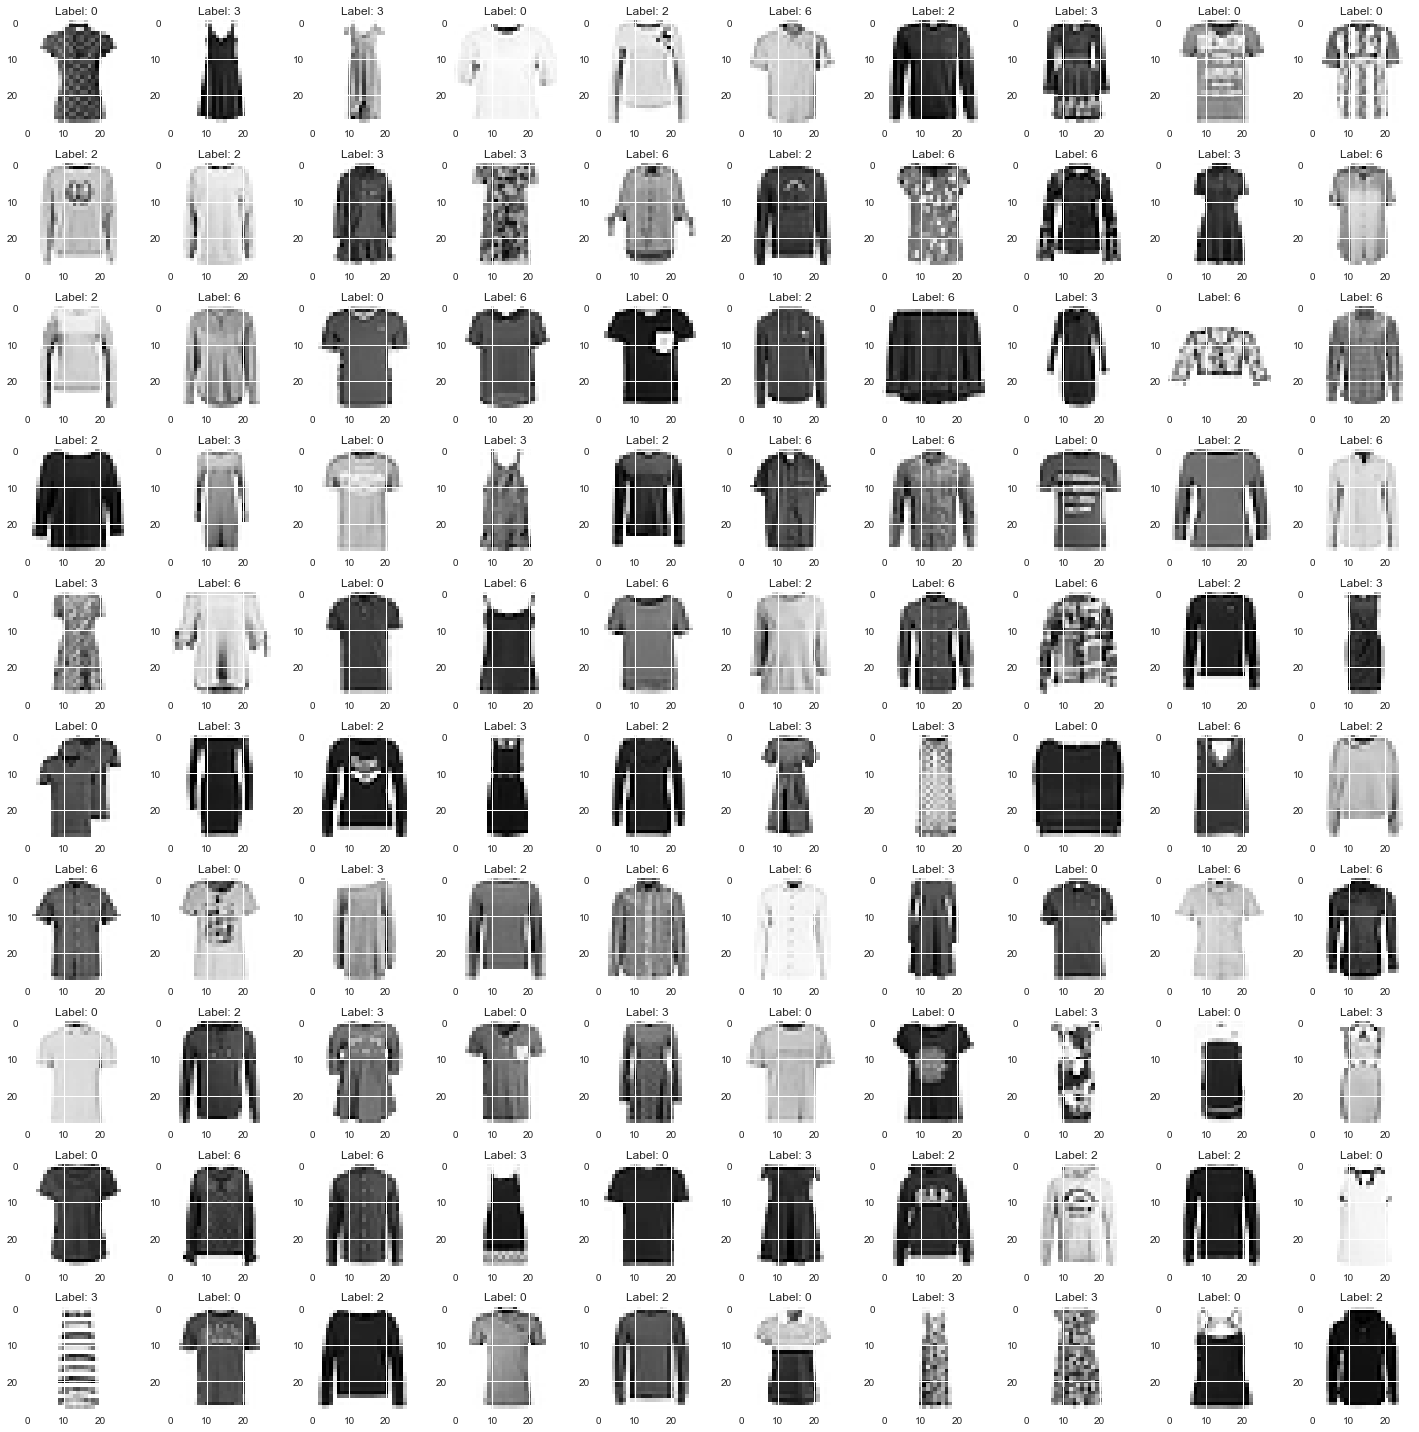

In [10]:
random_indices = np.random.permutation(train_images.shape[0]) #generate random indices for plotting
plot_multiple_data(10, 10, random_indices)

After seeing the above subplots, we can say that:
* Label 0 is for Half sleeve T-shirts/Tops
* Label 2 is for Long sleeve T-shirts or Pullovers
* Label 3 is for Dress
* Label 6 is for Shirts

Now, as we have gained some insights about the data, it will be better to start pre-processing the data.

### Data Pre-processing

In [23]:
#setting random seed so that every time we run random, we get the same result
np.random.seed(42)

#### Splitting the available training data into train and validation sets

It is not appropriate to evaluate the classification model's performance on the same data it was trained upon. So, here, we will split the provided training data into two sets: Training and validation. Here, we'll use `scikit-learn`'s `train_test_split` to split the data into 90:10 ratio. 90% data is for training and rest of the 10% for validation.

In [12]:
Train_x, Val_x, Train_y, Val_y = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

In [13]:
print(f"Shape of Training features: {Train_x.shape}")
print(f"Shape of Training labels: {Train_y.shape}")
print(f"Shape of Validation features: {Val_x.shape}")
print(f"Shape of Validation labels: {Val_y.shape}")  

Shape of Training features: (7200, 784)
Shape of Training labels: (7200,)
Shape of Validation features: (800, 784)
Shape of Validation labels: (800,)


#### Pre-processing for CNN classifier

Convolution Neural Networks (CNN) require images to be in 2D shape while in our case each image is a vector of 784 length. The vector form will work with other machine learning algorithms. Other than reshaping the representation of images, two more steps have to be performed for CNN, that are normalizing and one-hot encoding of labels. Hence, the following pre-processing steps are exclusive to CNN  based classifier. 

##### Reshaping the Train_x and Val_x 

Following function, `reshape_vector` will take in the datasets with images in the vector form and will return datasets with reshaped representation of images. Each of the image will be represented by a matrix of shape, 28 x 28 x 1. Since the images are black and white, 3rd dimension is equal to 1. 

In [14]:
def reshape_vector(Train_x, Val_x):
    return Train_x.reshape((-1, 28, 28, 1)), Val_x.reshape((-1, 28, 28, 1))

##### Normalizing by scaling down pixel values to the range [0, 1]

Range of pixel values is 0 to 255. If we normalize the pixel values to a smaller range of 0 to 1, the model will be able to learn the real structures instead of dealing with the scale differences. By doing so, learning agent can get stable gradient feedbacks avoiding scale differences of different dimensions. This provides faster learning and eventually leds to a better minima.

In [15]:
def normalize(Train_x, Val_x): 
    return Train_x.astype("float32") / 255.0, Val_x.astype("float32") / 255.0

##### One-hot encoding Labels

Later in the notebook, CNN classifier instead of directly outputting one of the classes, it will be outputting probabilities corresponding to each class. So, the output will always be in the range: [0, 1]. As, in our case, labels are 0, 2, 3 and 6, it is required to transform these labels and represent them in the form of 0 and 1. This transformation is nothing but one-hot encoding. <br>
Here `pandas`' `get_dummies` method will come in handy that will easily transorm the data in required encoded form.

In [16]:
def one_hot_encode(Train_y, Val_y):
    return pd.get_dummies(Train_y), pd.get_dummies(Val_y)

### Classification 

Now, as we are done with all the pre-processing, we can start trying machine learning algorithms and choose the one which outperforms all of the other ones.

#### 1. Using K-Nearest Neighbors Classifier

In [17]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(Train_x, Train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [18]:
neigh_predictions = neigh.predict(Val_x)

In [19]:
neigh_accuracy = accuracy_score(Val_y, neigh_predictions)
print(f'Accuracy score of KNN Classifier: {neigh_accuracy}')

Accuracy score of KNN Classifier: 0.78


In [56]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot = True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels[::-1])

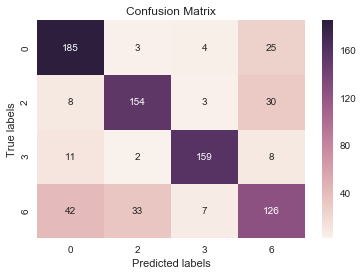

In [57]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Val_y, neigh_predictions, labels)

In [20]:
neigh_classification_report = classification_report(Val_y, neigh_predictions)
print(f'Classification report of KNN Classifier: \n{neigh_classification_report}')

Classification report of KNN Classifier: 
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       217
           2       0.80      0.79      0.80       195
           3       0.92      0.88      0.90       180
           6       0.67      0.61      0.63       208

   micro avg       0.78      0.78      0.78       800
   macro avg       0.78      0.78      0.78       800
weighted avg       0.78      0.78      0.78       800



#### 2. Using Random Forest Classifier

In [64]:
forest = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=100)
forest.fit(Train_x, Train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
forest_predictions = forest.predict(Val_x)

In [66]:
forest_accuracy = accuracy_score(Val_y, forest_predictions)
print(f'Accuracy score of Random Forest Classifier: {forest_accuracy}')

Accuracy score of Random Forest Classifier: 0.8175


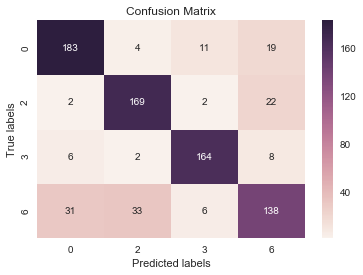

In [67]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Val_y, forest_predictions, labels)

In [68]:
forest_classification_report = classification_report(Val_y, forest_predictions)
print(f'Classification report of Random Forest Classifier: \n{forest_classification_report}')

Classification report of Random Forest Classifier: 
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       217
           2       0.81      0.87      0.84       195
           3       0.90      0.91      0.90       180
           6       0.74      0.66      0.70       208

   micro avg       0.82      0.82      0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



#### 3. Using Support Vector Classifier

In [69]:
svc = SVC(C=10, kernel='poly', gamma='auto')
svc.fit(Train_x, Train_y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
svc_predictions = svc.predict(Val_x)

In [71]:
svc_accuracy = accuracy_score(Val_y, svc_predictions)
print(f'Accuracy score of Support Vector Classifier: {svc_accuracy}')

Accuracy score of Support Vector Classifier: 0.805


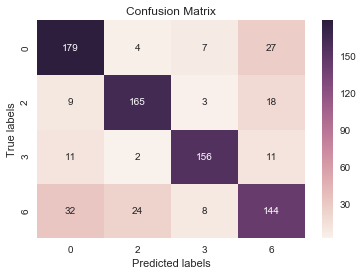

In [72]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Val_y, svc_predictions, labels)

In [73]:
svc_classification_report = classification_report(Val_y, svc_predictions)
print(f'Classification report of Support Vector Classifier: \n{svc_classification_report}')

Classification report of Support Vector Classifier: 
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       217
           2       0.85      0.85      0.85       195
           3       0.90      0.87      0.88       180
           6       0.72      0.69      0.71       208

   micro avg       0.81      0.81      0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.80       800



#### 4. Using Convolutional Neural Networks

In [17]:
Train_x, Val_x = reshape_vector(Train_x, Val_x)
Train_x, Val_x = normalize(Train_x, Val_x)
Train_y, Val_y = one_hot_encode(Train_y, Val_y)

##### Model 1

In [80]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (28,28,1), activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.50))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.50))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 32, activation = "relu"))
model.add(Dense(units = 4, activation = "softmax"))

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [82]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.001), metrics =['accuracy'])

In [83]:
epochs = 25
batch_size=64
history = model.fit(Train_x, Train_y,
                     batch_size = batch_size,
                     epochs = epochs,
                     verbose = 2,
                     validation_data = (Val_x, Val_y))

Train on 7200 samples, validate on 800 samples
Epoch 1/25
 - 27s - loss: 1.0225 - acc: 0.5138 - val_loss: 0.8410 - val_acc: 0.6325
Epoch 2/25
 - 25s - loss: 0.7782 - acc: 0.6558 - val_loss: 0.6936 - val_acc: 0.7000
Epoch 3/25
 - 24s - loss: 0.6804 - acc: 0.7008 - val_loss: 0.6132 - val_acc: 0.7462
Epoch 4/25
 - 26s - loss: 0.6215 - acc: 0.7399 - val_loss: 0.5858 - val_acc: 0.7712
Epoch 5/25
 - 25s - loss: 0.5801 - acc: 0.7626 - val_loss: 0.5523 - val_acc: 0.7700
Epoch 6/25
 - 26s - loss: 0.5502 - acc: 0.7756 - val_loss: 0.5463 - val_acc: 0.7688
Epoch 7/25
 - 25s - loss: 0.5176 - acc: 0.7937 - val_loss: 0.5139 - val_acc: 0.7850
Epoch 8/25
 - 27s - loss: 0.5059 - acc: 0.7965 - val_loss: 0.5421 - val_acc: 0.7788
Epoch 9/25
 - 26s - loss: 0.4930 - acc: 0.8032 - val_loss: 0.4872 - val_acc: 0.8000
Epoch 10/25
 - 24s - loss: 0.4718 - acc: 0.8151 - val_loss: 0.4689 - val_acc: 0.7987
Epoch 11/25
 - 25s - loss: 0.4645 - acc: 0.8146 - val_loss: 0.4668 - val_acc: 0.8163
Epoch 12/25
 - 24s - loss: 

In [94]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

In [118]:
def plot_loss_acc(history, n_epochs):
    
    history_record = []
    history_record.append(history.history['loss'])
    history_record.append(history.history['acc'])
    history_record.append(history.history['val_loss'])
    history_record.append(history.history['val_acc'])
    
    fig = plt.figure(figsize=(8, 4))
    
    for i in range(1, 3):
        plt.subplot(1, 2, i)
        plt.plot(np.arange(n_epochs), history_record[i - 1], label = "Training")
        plt.plot(np.arange(n_epochs), history_record[i + 1], label = "Validation")
        plt.xlabel('Epochs')
        if(i % 2 != 0):
            plt.ylabel('Loss function values')
        else:
            plt.ylabel('Accuracy values')
        plt.legend()
        
    fig.tight_layout()
    plt.show()
    

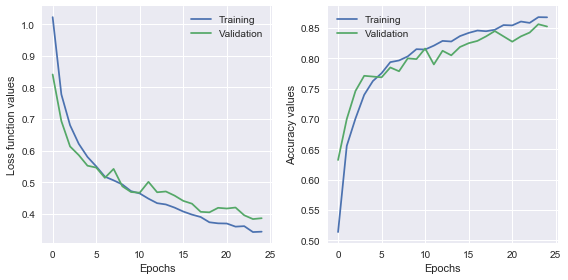

In [119]:
plot_loss_acc(history, 25)

In [131]:
predictions = model.predict(Val_x)

In [132]:
model.predict(Val_x[0].reshape(1, 28, 28, 1))

array([[6.5609009e-04, 8.4759516e-01, 4.0542818e-05, 1.5170820e-01]],
      dtype=float32)

In [155]:
prediction_dict = {0: 0, 1: 2, 2: 3, 3: 6}
CNN_predictions = np.zeros(len(predictions))
for i in range(len(predictions)):
    arg_max = np.argmax(predictions[i])
    CNN_predictions[i] = prediction_dict[arg_max]

In [159]:
Orig_Val_y = Val_y.values.argmax(axis=1)
Orig_Val_y = np.array([prediction_dict[y] for y in Orig_Val_y])

In [164]:
Orig_Val_y[:5]

array([2, 2, 0, 2, 3])

In [165]:
CNN_predictions[:5]

array([2., 2., 0., 2., 3.])

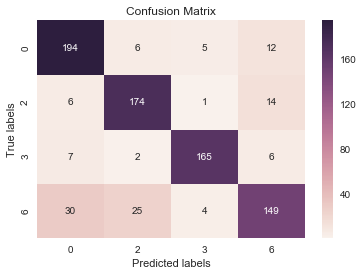

In [160]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Orig_Val_y, CNN_predictions, labels)

In [121]:
model.save(f'{PATH}//model-1.h5')

In [177]:
del model

##### Model 2

In [18]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5, 5), input_shape = (28,28,1), padding = "same", activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.50))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.50))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(units = 4, activation = "softmax"))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [229]:
model.compile(loss = 'categorical_crossentropy', optimizer= Adam(lr=0.001), metrics =['accuracy'])

In [230]:
epochs = 40
batch_size=64

aug = ImageDataGenerator(rotation_range=20, zoom_range=(0.9, 1.1),
width_shift_range=0.1, height_shift_range=0.1, shear_range=0.5,
horizontal_flip=True, fill_mode="nearest")
 
history = model.fit_generator(aug.flow(Train_x, Train_y, batch_size = batch_size),
validation_data=(Val_x, Val_y), epochs = epochs)

Epoch 1/40
113/113 [==============================] - 74s 651ms/step - loss: 1.1390 - acc: 0.4657 - val_loss: 0.8487 - val_acc: 0.6338
Epoch 2/40
113/113 [==============================] - 72s 639ms/step - loss: 0.8365 - acc: 0.6380 - val_loss: 0.6960 - val_acc: 0.6763
Epoch 3/40
113/113 [==============================] - 73s 644ms/step - loss: 0.7550 - acc: 0.6784 - val_loss: 0.6485 - val_acc: 0.7063
Epoch 4/40
113/113 [==============================] - 75s 660ms/step - loss: 0.7259 - acc: 0.6919 - val_loss: 0.6373 - val_acc: 0.7150
Epoch 5/40
113/113 [==============================] - 72s 640ms/step - loss: 0.6868 - acc: 0.7132 - val_loss: 0.6597 - val_acc: 0.6975
Epoch 6/40
113/113 [==============================] - 76s 669ms/step - loss: 0.6769 - acc: 0.7172 - val_loss: 0.6188 - val_acc: 0.7300
Epoch 7/40
113/113 [==============================] - 73s 646ms/step - loss: 0.6621 - acc: 0.7176 - val_loss: 0.6263 - val_acc: 0.7125
Epoch 8/40
113/113 [==============================] - 7

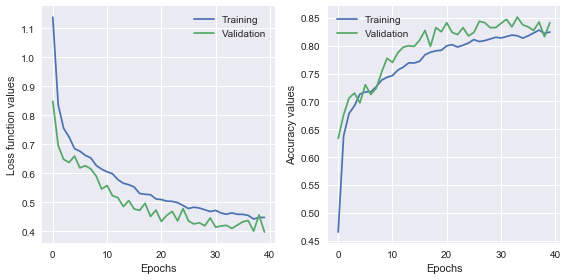

In [231]:
plot_loss_acc(history, 40)

In [232]:
predictions = model.predict(Val_x)

In [233]:
prediction_dict = {0: 0, 1: 2, 2: 3, 3: 6}
CNN_predictions = np.zeros(len(predictions))
for i in range(len(predictions)):
    arg_max = np.argmax(predictions[i])
    CNN_predictions[i] = prediction_dict[arg_max]

In [234]:
Orig_Val_y = Val_y.values.argmax(axis=1)
Orig_Val_y = np.array([prediction_dict[y] for y in Orig_Val_y])

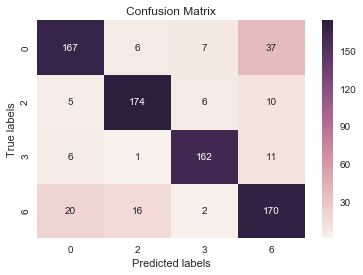

In [237]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Orig_Val_y, CNN_predictions, labels)

In [238]:
model.save(f'{PATH}//model-2')

### Generating prediction for Test set

In [24]:
with open(f'{PATH}\\test_image.pkl', 'rb') as image_file:
    test_images = pickle.load(image_file)

In [25]:
print(f'Number of test samples: {len(test_images)}')

Number of test samples: 2000


In [26]:
test_images = np.array(test_images)

In [27]:
print(f'Shape of test images: {test_images.shape}')

Shape of test images: (2000, 784)


In [28]:
test_images = test_images.reshape((-1, 28, 28, 1))
print(f'Shape of test images: {test_images.shape}')

Shape of test images: (2000, 28, 28, 1)


In [29]:
test_images = test_images.astype("float32") / 255.0

In [ ]:
test_predictions = model.predict(test_images)

In [ ]:
prediction_dict = {0: 0, 1: 2, 2: 3, 3: 6}
CNN_test_predictions = np.zeros(len(test_predictions))
for i in range(len(test_predictions)):
    arg_max = np.argmax(test_predictions[i])
    CNN_test_predictions[i] = prediction_dict[arg_max]